# Titanic Survivor Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

In [2]:
train=pd.read_csv("./titanic/train.csv")
test=pd.read_csv("./titanic/test.csv")
submission=pd.read_csv("./titanic/gender_submission.csv")

In [3]:
plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus']=False

In [4]:
#전처리 과정
train.drop({'Name','Ticket','Cabin'},axis=1,inplace=True)
test.drop({'Name','Ticket','Cabin'},axis=1,inplace=True)
train=train.replace('male',0)
train=train.replace('female',1)
test=test.replace('male',0)
test=test.replace('female',1)

In [5]:
train[train['Embarked'].isna()]
train['Embarked']=train['Embarked'].fillna('S')

Titanic에 탄 사람중 70%가 S에서 Embarked했다고 한다.

In [6]:
train['Embarked']=train['Embarked'].replace('S',0)
train['Embarked']=train['Embarked'].replace('C',1)
train['Embarked']=train['Embarked'].replace('Q',2)

C:\Users\suyeo\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\suyeo\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

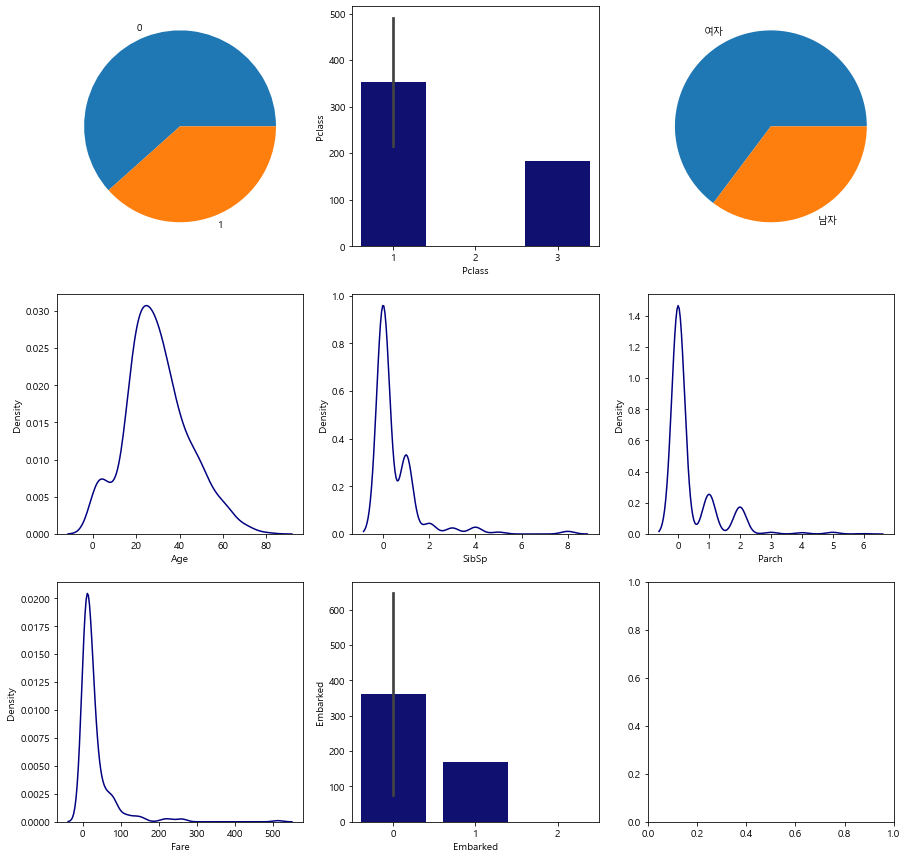

In [7]:
plt.figure(figsize=(15,15))
plt.subplot(331)
plt.pie(train['Survived'].value_counts(),labels=['0','1'])
plt.subplot(332)
sns.barplot(train['Pclass'],x=train['Pclass'].value_counts().index,y=train['Pclass'].value_counts(),color='navy')
plt.subplot(333)
plt.pie(train['Sex'].value_counts(),labels=['여자','남자'])
plt.subplot(334)
sns.kdeplot(train['Age'],color='navy')
plt.subplot(335)
sns.kdeplot(train['SibSp'],color='navy')
plt.subplot(336)
sns.kdeplot(train['Parch'],color='navy')
plt.subplot(337)
sns.kdeplot(train['Fare'],color='navy')
plt.subplot(338)
sns.barplot(train['Embarked'],x=train['Embarked'].value_counts().index,y=train['Embarked'].value_counts(),color='navy')
plt.subplot(339)

<AxesSubplot:>

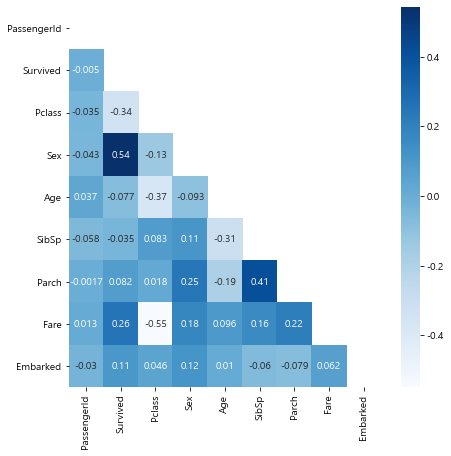

In [8]:
mask=np.zeros_like(train.corr(),dtype=bool)
mask[np.triu_indices_from(mask)]=True

plt.figure(figsize=(7,7))
sns.heatmap(train.corr(),annot=True,mask=mask,cmap='Blues')

Pclass & Fare, Sex & Survived, SibSp & Parch 는 상관관계가 있다

In [9]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64

Age의 NaN값을 예측하기 위해서 Survived, Pclass, Sex, SibSp, Parch, Fare값을 이용한다

In [10]:
Age_x=train[~train['Age'].isna()]
Age_y=train[train['Age'].isna()]

In [11]:
Age_x

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,0
1,2,1,1,1,38.0,1,0,71.2833,1
2,3,1,3,1,26.0,0,0,7.9250,0
3,4,1,1,1,35.0,1,0,53.1000,0
4,5,0,3,0,35.0,0,0,8.0500,0
...,...,...,...,...,...,...,...,...,...
885,886,0,3,1,39.0,0,5,29.1250,2
886,887,0,2,0,27.0,0,0,13.0000,0
887,888,1,1,1,19.0,0,0,30.0000,0
889,890,1,1,0,26.0,0,0,30.0000,1


In [12]:
features=['Survived','Sex','Pclass','SibSp','Parch','Fare']
target='Age'

Fare에는 outlier가 존재하기 때문에 Robust Scaler를 사용한다

In [13]:
rs=RobustScaler()
Age_x['Fare']=rs.fit_transform(Age_x['Fare'].to_frame(name='Fare'))

<ipython-input-13-15d15faca017>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Age_x['Fare']=rs.fit_transform(Age_x['Fare'].to_frame(name='Fare'))


In [14]:
Age_x

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,-0.335309,0
1,2,1,1,1,38.0,1,0,2.193153,1
2,3,1,3,1,26.0,0,0,-0.308655,0
3,4,1,1,1,35.0,1,0,1.475155,0
4,5,0,3,0,35.0,0,0,-0.303720,0
...,...,...,...,...,...,...,...,...,...
885,886,0,3,1,39.0,0,5,0.528462,2
886,887,0,2,0,27.0,0,0,-0.108261,0
887,888,1,1,1,19.0,0,0,0.563013,0
889,890,1,1,0,26.0,0,0,0.563013,1


In [15]:
X_train=Age_x[features]
X_test=Age_y[features]
Y_train=Age_x[target]
Y_train=Y_train.astype(int)

In [16]:
dmt=DecisionTreeClassifier(random_state=156)
lgb=LGBMClassifier()
lgb.fit(X_train,Y_train)
X_prediction=lgb.predict(X_test)

In [17]:
X_prediction

array([38, 42, 29, 29, 38, 38, 35, 38, 29, 38, 38, 35, 38, 35, 35, 35, 45,
       38, 38, 38, 38, 38, 38, 38, 35, 38, 38, 45, 24, 29, 38, 19, 50, 35,
       19, 24, 35, 35, 35, 38, 38, 19, 18, 38, 24, 29, 18, 35, 29, 35, 38,
       38, 35, 38, 28, 35, 35, 35, 38, 35, 42, 38, 35, 19, 35, 35, 38, 35,
       35, 29, 38, 38, 35, 29, 38, 35, 38, 38, 24, 38, 29, 28, 38, 38, 29,
       38, 35, 38, 35, 38, 35, 38, 38, 28, 29, 29, 35, 28, 24, 35, 24, 35,
       29, 35, 38, 35, 29, 29, 35, 29, 31, 24, 42, 38, 35, 38, 38, 38, 29,
       38, 18, 38, 38, 27, 35, 29, 38, 35, 29, 35, 38, 38, 47, 35, 35, 29,
       38, 38, 38, 38, 35, 28, 38, 35, 38, 45, 35, 35, 38, 28, 38, 38, 35,
       24, 35, 35, 29, 38, 38, 24, 38, 24, 35, 47, 29, 35, 38, 29, 38, 35,
       19, 35, 29, 24, 24, 38, 18])

In [18]:
Age_y.reset_index(inplace=True)
Age_y['Age']=X_prediction

<ipython-input-18-700c3661ee21>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Age_y['Age']=X_prediction


In [19]:
new_train=pd.concat([Age_x,Age_y],axis=0)

In [20]:
new_train=new_train.sort_index()

In [21]:
new_train.drop('index',axis=1,inplace=True)

In [37]:
new_train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,-0.5000,1,0,-0.335309,0
0,6,0,3,0,0.5000,0,0,8.458300,2
1,18,1,2,0,0.7500,0,0,13.000000,0
1,2,1,1,1,0.5000,1,0,2.193153,1
2,20,1,3,1,-0.0625,0,0,7.225000,1
...,...,...,...,...,...,...,...,...,...
885,886,0,3,1,0.5625,0,5,0.528462,2
886,887,0,2,0,-0.1875,0,0,-0.108261,0
887,888,1,1,1,-0.6875,0,0,0.563013,0
889,890,1,1,0,-0.2500,0,0,0.563013,1


In [38]:
Age_train_t=test[~test['Age'].isna()]
Age_test_t=test[test['Age'].isna()]

In [39]:
Age_train_t['Fare']=rs.fit_transform(Age_train_t['Fare'].to_frame(name='Fare'))

In [40]:
features=['Sex','Pclass','SibSp','Parch','Fare']
target='Age'

In [43]:
X_train=Age_train_t[features]
X_test=Age_test_t[features]
Y_train=Age_train_t[target]
X_train.fillna(0,inplace=True)
Y_train=Y_train.astype(int)

C:\Users\suyeo\Anaconda3\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [47]:
Age_train_t

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0,0.145833,0,0,-0.117712,Q
1,893,3,1,0.666667,1,0,-0.123084,S
2,894,2,0,1.291667,0,0,-0.105674,Q
3,895,3,0,-0.166667,0,0,-0.112314,S
4,896,3,1,-0.375000,1,1,-0.088831,S
...,...,...,...,...,...,...,...,...
413,1305,3,0,1.125000,0,0,1.634394,S
414,1306,1,1,0.333333,0,0,0.537033,C
415,1307,3,0,0.312500,0,0,-0.121464,S
416,1308,3,0,1.125000,0,0,1.634394,S


In [44]:
lgb.fit(X_train,Y_train)
X_prediction=lgb.predict(X_test)

ValueError: Input data must be 2 dimensional and non empty.

In [28]:
Age_test_t.reset_index(inplace=True)
Age_test_t['Age']=X_prediction
Age_test_t=Age_test_t.set_index('index')
test=pd.concat([Age_train_t,Age_test_t],axis=0)
test=test.sort_index()

<ipython-input-28-f196a7b0cbee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Age_test_t['Age']=X_prediction


In [48]:
test

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0,0.145833,0,0,-0.250766,Q
1,893,3,1,0.666667,1,0,-0.276215,S
2,894,2,0,1.291667,0,0,-0.193734,Q
3,895,3,0,-0.166667,0,0,-0.225192,S
4,896,3,1,-0.375000,1,1,-0.113939,S
...,...,...,...,...,...,...,...,...
413,1305,3,0,1.125000,0,0,8.050000,S
414,1306,1,1,0.333333,0,0,2.851149,C
415,1307,3,0,0.312500,0,0,-0.268542,S
416,1308,3,0,1.125000,0,0,8.050000,S


In [49]:
features=['Pclass','Sex','Age','SibSp']
target='Survived'

In [50]:
new_train['Age']=rs.fit_transform(new_train['Age'].to_frame(name='Age'))
test['Age']=rs.fit_transform(test['Age'].to_frame(name='Age'))

In [51]:
X_train=new_train[features]
X_test=test[features]
Y_train=new_train[target]

In [52]:
lgb.fit(X_train,Y_train)

LightGBMError: Number of classes should be specified and greater than 1 for multiclass training

In [34]:
X_test.fillna(0,inplace=True)

C:\Users\suyeo\Anaconda3\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [53]:
result=lgb.predict(X_test)

LightGBMError: The number of features in data (4) is not the same as it was in training data (5).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [36]:
result

NameError: name 'result' is not defined

In [112]:
submission_result=submission.copy()

In [113]:
submission_result['Survived']=result

In [114]:
submission_result.to_csv("submission.csv",index=False)